### 1. 

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

# Define paths
base_dir = '/app/data/Datasets/glass_and_other-split'  # Update this path to match your dataset location
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the training data into training and validation sets
)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Use training subset
)

val_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Use validation subset
)

datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Load the DenseNet201 model with pre-trained weights from ImageNet
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers to prevent training
base_model.trainable = False

# Add new layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv', append=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, csv_logger]
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'], steps_per_execution=32)

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, csv_logger]
)

# Plot training & validation accuracy and loss
def plot_training_history(history, history_fine_tune=None):
    acc = history.history['accuracy'] + (history_fine_tune.history['accuracy'] if history_fine_tune else [])
    val_acc = history.history['val_accuracy'] + (history_fine_tune.history['val_accuracy'] if history_fine_tune else [])
    loss = history.history['loss'] + (history_fine_tune.history['loss'] if history_fine_tune else [])
    val_loss = history.history['val_loss'] + (history_fine_tune.history['val_loss'] if history_fine_tune else [])
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history, history_fine_tune)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Save the model
model.save('glass_classification_model.h5')


### 2.

In [ ]:
# %pip install keras-tuner

In [1]:
import os
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201, EfficientNetB0, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import mixed_precision
from tensorflow.keras.backend import clear_session

clear_session()  # This frees the GPU memory


# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
base_dir = '/app/data/Datasets/glass_and_other-split'  # Update this path to match your dataset location
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Image parameters
img_height, img_width = 128, 128
batch_size = 8 #16 #32

# Data augmentation and data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    validation_split=0.2  # Split the training data into training and validation sets
)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Use training subset
)

val_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Use validation subset
)

datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Define the model-building function for Keras Tuner
def build_model(hp):
    # Tune between different base models
    base_model_choice = hp.Choice('base_model', ['DenseNet201', 'EfficientNetB0', 'MobileNetV3Small'])

    if base_model_choice == 'DenseNet201':
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif base_model_choice == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    else:
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    base_model.trainable = False  # Freeze the base model layers initially

    # Create the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Tune the number of neurons in the dense layer
    units = hp.Int('units', min_value=128, max_value=1024, step=128)
    x = Dense(units, activation='relu')(x)

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(x)

    # Output layer
    predictions = Dense(1, activation='sigmoid')(x)

    # Compile the model with a tunable learning rate and optimizer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Tune optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    else:
        optimizer = SGD(learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-3, sampling='LOG'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    # max_epochs=20,
    # factor=3,
    max_trials=5,
    directory='hyperparam_tuning',
    project_name='glass_classification'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv', append=True)

# Search for the best hyperparameters
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best model summary
print("Best model summary:")
best_model.summary()

# Fine-tune the best model by unfreezing the base layers
base_model = best_model.layers[0]  # Get the base model
base_model.trainable = True

# Compile the model again for fine-tuning with a lower learning rate
best_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the fine-tuned model
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, csv_logger]
)


Trial 5 Complete [00h 00m 38s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 05m 42s
Best model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 5,198,244 (19.83 MB)

 Trainable params: 1,148,673 (4.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.7934 - loss: 0.5170 - val_accuracy: 0.8007 - val_loss: 0.5035 - learning_rate: 1.0000e-05
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8750 - loss: 0.3874 - val_accuracy: 0.8571 - val_loss: 0.4120 - learning_rate: 1.0000e-05
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7908 - loss: 0.5182 - val_accuracy: 0.8007 - val_loss: 0.5001 - learning_rate: 1.0000e-05
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.8750 - loss: 0.3805 - val_accuracy: 0.8571 - val_loss: 0.4162 - learning_rate: 1.0000e-05
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8150 - loss: 0.4803 - val_accuracy: 0.8007 - val_loss: 0.5002 - learning_rate: 1.0000e-05
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.8750 - loss: 0.4171 - val_accuracy: 0.8571 - val_loss: 0.4261 - learning_rate: 5.0000e-06
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - 

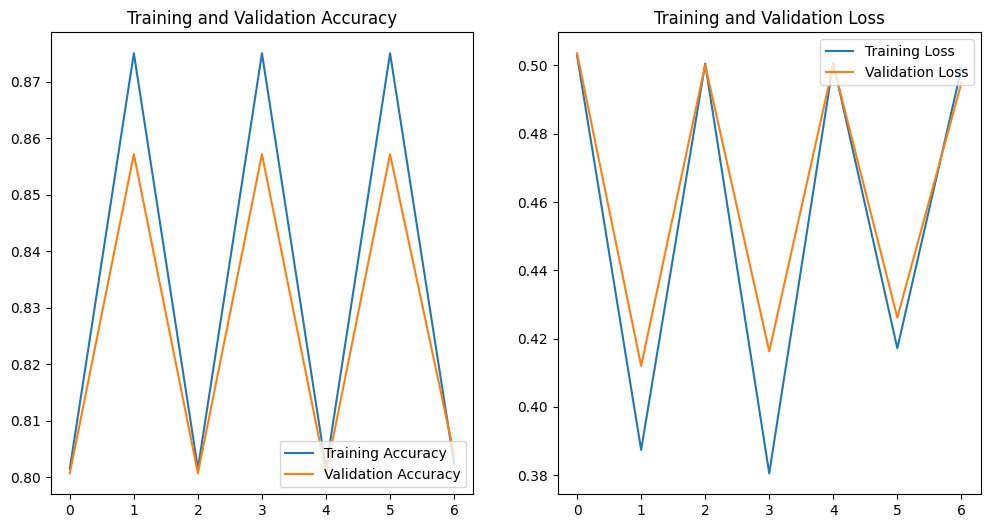

60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4682 - loss: 1.0421

2024-09-12 15:53:15.889729: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.118 = (f32[3,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,3,129,129]{3,2,1,0} %pad.10, f32[32,3,3,3]{3,2,1,0} %transpose.89), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="functional_1/stem_conv_1/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18350080 bytes.

To ignore this failure and try to use a fallback algorithm (which may have subop

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_4427/2581244026.py", line 152, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 343, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.118 = (f32[3,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,3,129,129]{3,2,1,0} %pad.10, f32[32,3,3,3]{3,2,1,0} %transpose.89), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="functional_1/stem_conv_1/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18350080 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_87447]

In [2]:

# Plot training & validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

# Evaluate the model on test data
test_loss, test_acc = best_model.evaluate(test_generator, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Save the best model
best_model.save('best_glass_classification_model.h5')
